In [ ]:
# INSTALL EXTRA PACKAGES
!pip install evaluate
!pip install -q -U keras-tuner

# Kaggle notebook

 The free version of Google Colab was insufficient to handle the additional resource usage required. As a result, we opted to perform the training on Kaggle instead.


In [ ]:
# GENERAL IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import re
import seaborn as sns


In [ ]:
# NN IMPORTS
import tensorflow as tf
import evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Embedding, Reshape

import keras_tuner as kt

2024-05-31 16:07:51.186386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 16:07:51.186439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 16:07:51.187944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# DATASET

# KAGGLE PATH
base_path="/kaggle/input/reviews"

dataset_path = os.path.join(base_path, "dataset")
dataset_path_train = dataset_path

folder_human_samples = "/human"
folder_bot_samples = "/bot"
os.listdir(dataset_path)
print(len(os.listdir(dataset_path_train+folder_human_samples)))
print(len(os.listdir(dataset_path_train+folder_bot_samples)))

tf.random.set_seed(42)


12500
7811


# Data loading

Human reviews have a wide range of lengths. We define a range to consider, and we enforced the fake reviews to be distributed in that range.

The remaining human reviews are not necessary and discarded.

In [ ]:
# PARAMETERS
limit_file =7500 # max number of files for each class

# PREPROCESSING
min_review_size_char = 500
min_review_size_word = 100
max_review_size_char = 2400
desired_size_char = 2000  # this is the actual max_length for each input file

# Map of the expected value to their labels with id_TO_label and label_TO_id
def id_to_label(id):
  if id == 0:
    return "BOT"
  else:
    return "HUMAN"
def label_to_id(label):
  if label in ["FAKE","Fake","fake", "BOT","Bot","bot"]:
    return 0
  else:
    return 1

# Preprocessing phase

We run these steps in order to standardize the data:
- removing unnecessary spaces and blank lines
- filtering out html tags (in detail, words encased in <.....> )
- replacing multiple punctuation marks with a single one
- transforming everything to lowercase

## Data conversion

We implemented this step to have an easier handling of the data. Our model takes numerical inputs, which are the ascii representation of the texts.


In [ ]:
# PREPROCESSING FUNCTION

# this function aim to create uniformity between files, to make them have the same shape

def preprocess(text):
    cleaned_text = ""
    del cleaned_text
    # Remove spaces, newlines, and extra spaces
    cleaned_text = ' '.join(re.sub(r'\s+', ' ', text).split())

    # Remove HTML tags (including <br>)
    cleaned_text = re.sub(r'<.*?>', '', cleaned_text)

    # Replace multiple punctuation marks with a single one
    cleaned_text = re.sub(r'[!?.]+', '.', cleaned_text)

    # Convert all characters to lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text

# CONVERSION CHAR TO INT

def convert_char2int_array(matrix,raw_data,row_index):
  col_index = 0
  for c in raw_data[0]:
    # truncation happens for input elements over the desired size
    if(col_index >= desired_size_char):
      break
    matrix[row_index][col_index] = ord(c)
    col_index += 1

def convert_char2int_matrix(dataset):
  # Padding value: zero (as number, not ascii)
  numerical_dataset = np.zeros((len(dataset),desired_size_char))
  index = 0
  for line in dataset:
    # calling a conversion on each row
    convert_char2int_array(numerical_dataset,line, index)
    index+=1
  return numerical_dataset



In [ ]:
 # DATASET LOADING
full_dataset_reviews=[]
list_char = []
list_words = []
np.seterr(all="ignore")

def create_dataset_entry(count, review, target_dataset, label):
    if count % (limit_file / 10) == 0:
        print(f"Files {label} scanned: {count}")
    entry = [preprocess(review)]
    target_dataset.append(entry)

def import_folder(path, target_dataset, label):
    count_file = 0
    # open the dataset folder
    for root, dirs, files in os.walk(path):
        for file in files:
            #avoid dirty files
            if file.endswith(".txt"):
              if(count_file>=limit_file):
                break
              else:
                # make a new dataset entry
                with open(os.path.join(root, file), 'r') as f:
                    full_text = f.read()

                    # also generate a word_count and char_count for tracking how big that file is
                    count_char = len(full_text)
                    count_word = len(full_text.split())

                    #skip reviews that are too short or too long
                    if ((count_char < max_review_size_char) and (count_char > min_review_size_char) and (count_word > min_review_size_word)):

                      create_dataset_entry(count_file,full_text,target_dataset, label)
                      #update counter to compare it to file_limit
                      count_file += 1
                      list_char.append(count_char)
                      list_words.append(count_word)
    return count_file


# import human reviews
human_reviews_count = import_folder(dataset_path_train+folder_human_samples,full_dataset_reviews, id_to_label(1))

# import bot reviews
bot_reviews_count = import_folder(dataset_path_train+folder_bot_samples,full_dataset_reviews, id_to_label(0))


print("File umani caricati: ", human_reviews_count)
print("File bot caricati: ", bot_reviews_count)
print("Righe del dataset: ", len(full_dataset_reviews))
print(len(list_char))


full_dataset_reviews_num = convert_char2int_matrix(full_dataset_reviews)

Files HUMAN scanned: 0
Files HUMAN scanned: 750
Files HUMAN scanned: 1500
Files HUMAN scanned: 2250
Files HUMAN scanned: 3000
Files HUMAN scanned: 3750
Files HUMAN scanned: 4500
Files HUMAN scanned: 5250
Files HUMAN scanned: 6000
Files HUMAN scanned: 6750
Files BOT scanned: 0
Files BOT scanned: 750
Files BOT scanned: 1500
Files BOT scanned: 2250
Files BOT scanned: 3000
Files BOT scanned: 3750
Files BOT scanned: 4500
Files BOT scanned: 5250
Files BOT scanned: 6000
Files BOT scanned: 6750
File umani caricati:  7500
File bot caricati:  7500
Righe del dataset:  15000
15000


# Labeling

Labels are applied exploiting that we loaded the samples one folder at a time. They are going to be shuffled later.

In [ ]:
# LABELING
def make_labels(positive_count,negative_count):
  human_labels = [1]*positive_count
  bot_labels = [0]*negative_count
  return human_labels+bot_labels

# promemoria: human files were loaded before bot files
full_labels = make_labels(human_reviews_count,bot_reviews_count)

# Tensor allocation

We used test_train_split from SKLearn to handle the split, and also the shuffling.

In [ ]:
# TENSORS ALLOCATION
trainX, testX, trainy, testy = train_test_split(full_dataset_reviews_num, full_labels, test_size=0.2, random_state=42)

trainX = np.array(trainX)
testX = np.array(testX)
trainy = np.array(trainy)
testy = np.array(testy)

# EARLY STOPPING: based on validation loss and patience
es_patience = EarlyStopping(monitor='val_loss', mode='min', patience=3)
es_delta = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.1)
# METRICS: we only have two classes
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

default_learning_rate = 1e-4

NN_callbacks_delta = [es_delta]
NN_callbacks_patience = [es_patience]
NN_batch_size = 50
NN_epochs = 20  # early stop is usually called before reaching this number
NN_split = 0.2  # split ratio between training and validation

# Model instantiation

This is the same refined model we have built from the smaller notebook, and we use the same function to prepare it for the tuner.

In [ ]:
# REFINED MODEL
def build_definitive_model(embed_dim,l1_size,l2_size,kernel_1,kernel_2,pool_1,pool_2,learning,drop):
  model = Sequential()

  model.add(Embedding(input_dim=NN_batch_size, output_dim=embed_dim,  input_length=desired_size_char))

  # KERNEL SIZE: calculated with Keras Tuner
  model.add(Conv1D(filters=l1_size, kernel_size=kernel_1, activation='relu', padding="valid"))
  # POOLING SIZE: calculated with Keras Tuner
  model.add(MaxPooling1D(pool_1,padding="valid"))
  # KERNEL SIZE: calculated with Keras Tuner
  model.add(Conv1D(filters=l2_size, kernel_size=kernel_2, activation='relu', padding="valid"))
  # POOLING SIZE: calculated with Keras Tuner
  model.add(MaxPooling1D(pool_2,padding="valid"))

  # DROPOUT RATE: calculated with Keras Tuner
  model.add(Flatten())

  model.add(Dropout(drop))

  model.add(Dense(1, activation='sigmoid'))
  model.build(trainX.shape)
  model.compile(loss=loss, optimizer=Adam(learning_rate=learning), metrics=[metrics])

  return model



# Keras tuner

The tuner has been run several times. We started from a wide range of parameters, and reduced it while also reducing the search step.
In this way we managed to avoid an even longer execution time.

In [ ]:
def build_model_tuner(hp):
  embed_dim = hp.Int('embedded_size', min_value=1700, max_value=2000, step=100)
  hp_units1 = hp.Int('units_l1', min_value=600, max_value=800, step=50)
  hp_units2 = hp.Int('units_l2', min_value=300, max_value=450, step=50)
  hp_k1 = hp.Int('kernel_l1', min_value=4, max_value=6, step=1)
  hp_k2 = hp.Int('kernel_l2', min_value=2, max_value=5, step=1)
  hp_window1 = hp.Int('pooling_size_l1', min_value=5, max_value=7, step=1)
  hp_window2 = hp.Int('pooling_size_l2', min_value=3, max_value=5, step=1)
  drop_10 = hp.Int('dropout_rate', min_value=2, max_value=4, step=1)
  learning = hp.Choice('learning_rate', values = [1e-3])
  model = build_definitive_model(embed_dim,hp_units1,hp_units2,hp_k1,hp_k2,hp_window1,hp_window2,learning,drop_10/10)
  return model

# TUNER USING HYPERBAND
# we've seen Hyperband having a good performance in laboratory lessons. We also liked the story behind the the armed bandit problem.
tuner = kt.Hyperband(build_model_tuner,
                     objective='val_binary_accuracy',
                     overwrite=True,
                     max_epochs=NN_epochs,
                     factor=3)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# TUNER SEARCH:

# CODE IS COMMENTED TO AVOID LONG EXECUTION TIME
tuner.search(trainX, trainy, epochs=NN_epochs, validation_split=NN_split, callbacks=NN_callbacks_delta)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 30 Complete [00h 03m 21s]
val_binary_accuracy: 0.9758333563804626

Best val_binary_accuracy So Far: 0.9891666769981384
Total elapsed time: 01h 34m 48s


# Tuner results

We obtained a set of hyperparameters that are going to be used for the final tests. We ignored the best number of epochs since we prefer to rely on the early stopping criteria.

In [ ]:
# BACKUP OF THE TUNER RESULTS
embed_dim = 1900
hp_units1 = 600 # same
hp_units2 = 450
hp_k1 = 6
hp_k2 = 3
hp_window1 = 7
hp_window2 = 5
drop_10 = 0.3
learning = 1e-3



In [ ]:
# PRINT TUNING RESULTS
def print_best_hp(hp_set):
  print("Best set of hyperparameters so far:")
  print(f"Embedding size: {hp_set.get('embedded_size')}")
  print(f"Conv1D layer 1 size: {hp_set.get('units_l1')}")
  print(f"Conv1d Kernel 1 size: {hp_set.get('kernel_l1')}")
  print(f"MaxPooling layer 1 size: {hp_set.get('pooling_size_l1')}")
  print(f"Conv1D layer 2 size: {hp_set.get('units_l2')}")
  print(f"Conv1d Kernel 2 size: {hp_set.get('kernel_l2')}")
  print(f"MaxPooling layer 2 size: {hp_set.get('pooling_size_l2')}")
  print(f"dropout: {hp_set.get('dropout_rate')}")
  print(f"learning rate: {hp_set.get('learning_rate')}")
print_best_hp(best_hps)

Best set of hyperparameters so far:
Embedding size: 1900
Conv1D layer 1 size: 600
Conv1d Kernel 1 size: 6
MaxPooling layer 1 size: 7
Conv1D layer 2 size: 450
Conv1d Kernel 2 size: 3
MaxPooling layer 2 size: 5
dropout: 3
learning rate: 0.001


In [ ]:
# BACKUP OF THE TUNER RESULTS
embed_dim = 1900
hp_units1 = 600 # same
hp_units2 = 450
hp_k1 = 6
hp_k2 = 3
hp_window1 = 7
hp_window2 = 5
drop_10 = 0.3
learning = 1e-3



# Baseline: Low_effort Network
We take again the low_effort network we did as first experiment where we did our first from-scratch model, to make a comparison.

In [ ]:
## DENSE NETWORK AS BASELINE
def build_model_low_effort():
  # notes: some dense layers without any real planning. it's a baseline with no design effort.
  model = Sequential()
  model.add(Flatten())

  model.add(Dense(2000, activation='relu'))
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.build(trainX.shape)
  model.compile(loss=loss, optimizer=Adam(learning_rate=learning), metrics=[metrics])

  return model


# Fair comparison: bigger dense model

Since the original dense model ended up being smaller than our refined model, it's unfair to say our is more accurate. So we make one more model, similar to the low_effort dense one, but having a similar dimension to our refined model.

In [ ]:
## DENSE NETWORK AS BASELINE
def build_big_dense():

  model = Sequential()
  model.add(Flatten())

  model.add(Dense(2400, activation='relu'))
  model.add(Dense(1200, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.build(trainX.shape)
  model.compile(loss=loss, optimizer=Adam(learning_rate=learning), metrics=[metrics])

  return model


In [ ]:
# empty arrays to save the results
histories = []
model_names = []
accuracy_results = []
accuracy_val_results = []
loss_results = []
loss_val_results = []
param_size = []


In [ ]:
# Models: time to assemble the best model with tuned hyperparameters

dense_model = build_model_low_effort()
final_model = build_definitive_model(embed_dim,hp_units1,hp_units2,hp_k1,hp_k2,hp_window1,hp_window2,learning,drop_10)
big_model= build_big_dense()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Model summaries


In [ ]:
dense_model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_26 (Flatten)            │ (12000, 2000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (12000, 2000)          │     4,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (12000, 1000)          │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (12000, 100)           │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (12000, 1)             │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,103,201 (23.28 MB)

 Trainable params: 6,103,201 (23.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
big_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_28 (Flatten)            │ (12000, 2000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (12000, 2400)          │     4,802,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (12000, 1200)          │     2,881,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (12000, 100)           │       120,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (12000, 1)             │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,803,801 (29.77 MB)

 Trainable params: 7,803,801 (29.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
final_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (12000, 2000, 1900)    │        95,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (12000, 1995, 600)     │     6,840,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (12000, 285, 600)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (12000, 283, 450)      │       810,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (12000, 56, 450)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (12000, 25200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (12000, 25200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (12000, 1)             │        25,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,771,251 (29.64 MB)

 Trainable params: 7,771,251 (29.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training phase

We train all the models in sequence. Each history is stored for the comparison.

In [ ]:
# Training dense model

history_1 = dense_model.fit(trainX, trainy, epochs=NN_epochs, batch_size=NN_batch_size, validation_split=NN_split, callbacks=NN_callbacks_patience)


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.8377 - loss: 41.3981 - val_binary_accuracy: 0.8233 - val_loss: 1.1138
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7668 - loss: 1.0875 - val_binary_accuracy: 0.7954 - val_loss: 0.4851
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7954 - loss: 0.5107 - val_binary_accuracy: 0.8238 - val_loss: 0.4367


In [ ]:
# Training dense model

history_2 = big_model.fit(trainX, trainy, epochs=NN_epochs, batch_size=NN_batch_size, validation_split=NN_split, callbacks=NN_callbacks_patience)


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.7699 - loss: 50.6915 - val_binary_accuracy: 0.8112 - val_loss: 1.0548
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.8154 - loss: 0.7841 - val_binary_accuracy: 0.8246 - val_loss: 0.4022
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.8250 - loss: 1.2652 - val_binary_accuracy: 0.8067 - val_loss: 2.9731


In [ ]:
def update_stats(name,history):
    model_names.append(name)
    param_size.append(count_params(dense_model.trainable_weights))
    accuracy_results.append(history.history['binary_accuracy'])
    accuracy_val_results.append(history.history['val_binary_accuracy'])
    loss_results.append(history.history['loss'])
    loss_val_results.append(history.history['val_loss'])

update_stats("dense",history_1)
update_stats("bigger dense",history_2)

In [ ]:
# Training refined model

original_history = final_model.fit(trainX, trainy, epochs=NN_epochs, batch_size=NN_batch_size, validation_split=NN_split, callbacks=NN_callbacks_patience)


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 83s 417ms/step - binary_accuracy: 0.8340 - loss: 0.3796 - val_binary_accuracy: 0.9529 - val_loss: 0.1287
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 80s 415ms/step - binary_accuracy: 0.9617 - loss: 0.1126 - val_binary_accuracy: 0.9800 - val_loss: 0.0606
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 80s 415ms/step - binary_accuracy: 0.9827 - loss: 0.0478 - val_binary_accuracy: 0.9812 - val_loss: 0.0642


In [ ]:
update_stats("refined",original_history)

# Final comparison

The refined model is compared to the initial low_effort model, and the bigger dense model.

In [ ]:
# PLOTTING the results so far
def plot_learning_curves(names, size):

    # SUBPLOTS: one model per row
    nrows = len(names)
    if nrows == 1:
      nrows +=1
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(14, 10))

    # calculating axis references
    min_acc_array = []
    for res in accuracy_results:
      min_acc_array.append(min(res))
    for res in accuracy_val_results:
      min_acc_array.append(min(res))
    max_los_array = []
    for res in loss_results:
      max_los_array.append(np.mean(res))
    for res in loss_val_results:
      max_los_array.append(np.mean(res))
    min_los_array = []
    for res in loss_results:
      min_los_array.append(min(res))
    for res in loss_val_results:
      min_los_array.append(min(res))

    maxacc = 1
    minacc = min(min_acc_array)
    maxloss = max(max_los_array)
    minloss = min(min_los_array)

    row_index = 0
    minacc = np.floor(minacc*100) * 0.01
    maxw = max(size)
    minw = min(size)/10
    for title in names:

      # FIRST COLUMN: accuracy
      axes[row_index, 0].set_ylim([minacc, maxacc])
      axes[row_index, 0].set_yticks(np.arange(minacc,maxacc,0.05))
      axes[row_index, 0].plot(accuracy_results[row_index], label='Training Accuracy - ' + title)
      axes[row_index, 0].plot(accuracy_val_results[row_index], label='Validation Accuracy - ' + title)
      axes[row_index, 0].set_xlabel('Epoch')
      axes[row_index, 0].set_ylabel('Accuracy')
      axes[row_index, 0].set_title('Training and Validation Accuracy - ' + title)
      axes[row_index, 0].legend()
      # SECOND COLUMN: loss
      axes[row_index, 1].set_ylim([minloss, 1+round(maxloss)])
      axes[row_index, 1].plot(loss_results[row_index], label='Training loss - ' + title)
      axes[row_index, 1].plot(loss_val_results[row_index], label='Validation loss - ' + title)
      axes[row_index, 1].set_xlabel('Epoch')
      axes[row_index, 1].set_ylabel('Loss')
      axes[row_index, 1].set_title('Training and Validation loss - ' + title)
      axes[row_index, 1].legend()
      # THIRD COLUMN: network size
      axes[row_index, 2].set_yscale('log')
      axes[row_index, 2].set_ylim([minw, maxw])
      axes[row_index, 2].set_xlim([0, 2])
      axes[row_index, 2].bar(1,size[row_index],linewidth=0.2, tick_label=title)
      axes[row_index, 2].set_title('Size - trainable parameters')

      row_index += 1
    plt.tight_layout()
    plt.show()


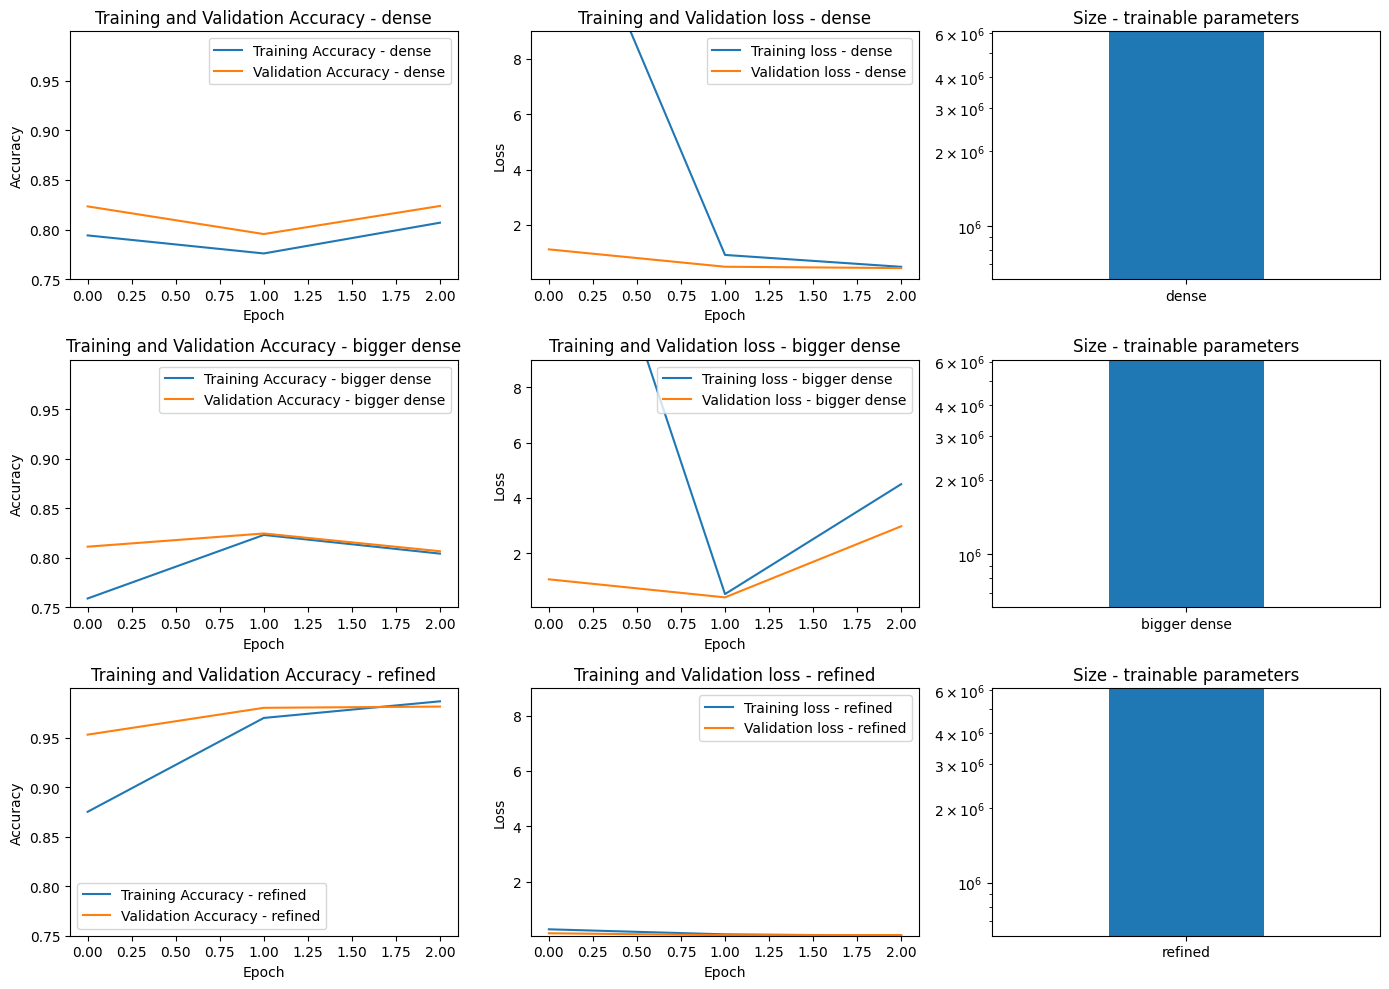

In [ ]:
plot_learning_curves(model_names, param_size)

# Testing phase

In [ ]:
# TEST PHASE, USING THE TEST SET
scores = list()

# evaluate model
_, test_accuracy = final_model.evaluate(testX, testy, batch_size=NN_batch_size, verbose=0)
test_accuracy = test_accuracy * 100.0
print('>#%d: %.3f' % (1, test_accuracy))
scores.append(test_accuracy)

# summarize results
m, s = np.mean(scores), np.std(scores)
print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

>#1: 98.600
Accuracy: 98.600% (+/-0.000)


In [ ]:
# CONFUSION MATRIX TO PLOT THE CLASSIFICATION RESULTS
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Bot Review Detected (True Negatives): ', cm[0][0])
  print('Bot Review Incorrectly Detected (False Positives): ', cm[0][1])
  print('Human Review Missed (False Negatives): ', cm[1][0])
  print('Human Review Detected (True Positives): ', cm[1][1])
  print('Human Reviews in the test set : ', np.sum(cm[1]))
  print('Fake Reviews in the test set : ', np.sum(cm[0]))


# Confusion matrix

We can finally see some mistakes, that were not present in the other notebook with the smaller dataset.

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step
Bot Review Detected (True Negatives):  1487
Bot Review Incorrectly Detected (False Positives):  6
Human Review Missed (False Negatives):  36
Human Review Detected (True Positives):  1471
Human Reviews in the test set :  1507
Fake Reviews in the test set :  1493


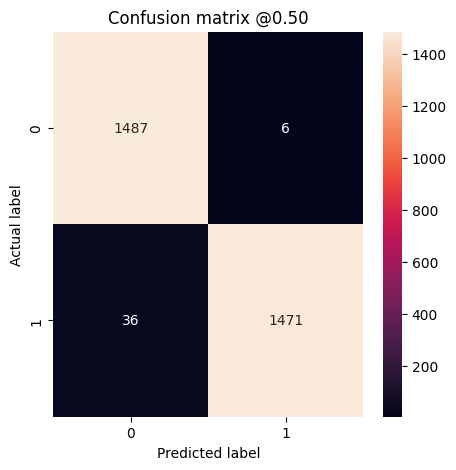

In [ ]:
test_predictions_baseline = final_model.predict(testX, batch_size=NN_batch_size)
plot_cm(testy, test_predictions_baseline)